In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbrn

fontsize = 13
custom = {"axes.edgecolor": "black","grid.linestyle": "dashed", "grid.color": "gray"}
sbrn.set_context('paper')
sbrn.set_style("whitegrid", rc = custom)

# Open the JSON file for reading
with open('july9onenodeosu.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [2]:
# Customize the x-axis ticks to show byte values more clearly
from matplotlib.ticker import FuncFormatter

def byte_formatter(x, pos):
    if x == 0:
        return '0 B'
    elif x < 1024:
        return f'{int(x)} B'
    elif x < 1024**2:
        return f'{int(x / 1024)} KB'
    else:
        return f'{int(x / 1024**2)} MB'

# Customize the y-axis ticks to show time values more clearly
def time_formatter(y, pos):
    if y < 1:
        return f'{y * 1000:.1f} ns'
    elif y < 1000:
        return f'{y:.1f} us'
    elif y < 1000000:
        return f'{y / 1000:.1f} ms'
    else:
        return f'{y / 1000000:.1f} s'

In [3]:
extracted_data = []

# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    
    # Determine the communication type from the name
    if 'KokkosComm' in name:
        comm_type = 'KokkosComm'
    elif 'MPI' in name:
        comm_type = 'MPI'
    else:
        continue  # Skip if neither
        
    # Determine the function type from the name
    if 'sendrecv' in name:
        func_type = 'send/recv'
    elif 'isendirecv' in name:
        func_type = 'isend/irecv'
    else:
        continue  # Skip if neither
        
    # Append the extracted information to the list
    if 'mean' in name:
        extracted_data.append({'comm_type': comm_type, 'func_type': func_type, 'real_time': real_time, 'bytes': bytes})

edf = pd.DataFrame(extracted_data)

# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['comm_type'] + ' ' + edf['func_type']

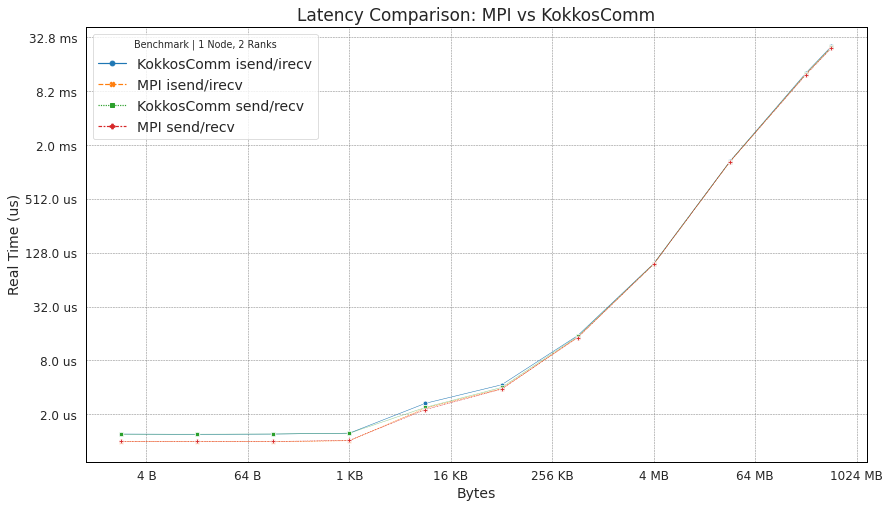

In [4]:
# mpirun -np 2 ./build/perf_tests/perf_test-main 
# --benchmark_repetitions=5 --benchmark_filter=osu 
# --benchmark_format=json > "output$(date '+%Y%m%d%H%M%S').json"

# Plot 0: Compare All
plt.figure(figsize=(14, 8))
plt.title('Latency Comparison: MPI vs KokkosComm', fontsize=fontsize + 4)

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=.5)

plt.legend(title='Benchmark | 1 Node, 2 Ranks', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=4)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/osu_latency_all.png", dpi=300)
plt.show()

In [5]:
# Define subsets to plot separately
subset1 = edf[(edf['comm_type'] == 'KokkosComm') & (edf['func_type'] == 'send/recv') | 
              (edf['comm_type'] == 'MPI') & (edf['func_type'] == 'send/recv')]

subset2 = edf[(edf['comm_type'] == 'KokkosComm') & (edf['func_type'] == 'isend/irecv') | 
              (edf['comm_type'] == 'MPI') & (edf['func_type'] == 'isend/irecv')]

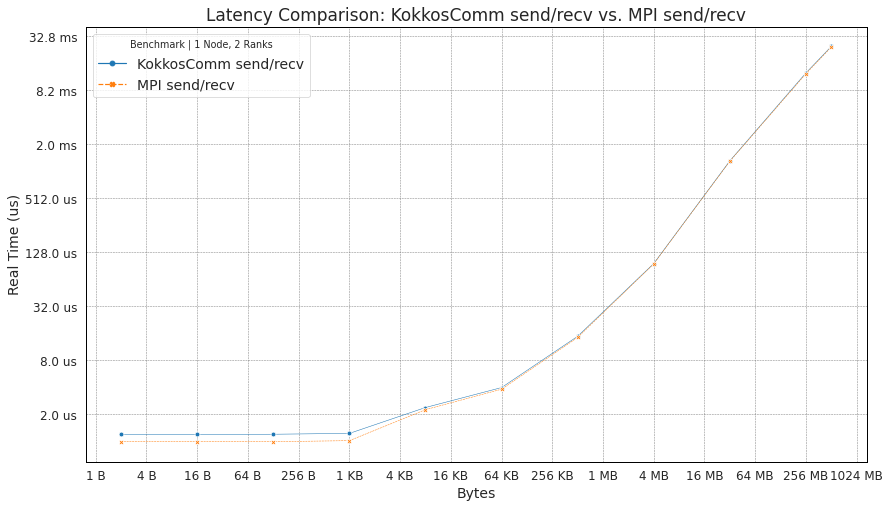

In [6]:
# Plot 1: KokkosComm send/recv vs. MPI send/recv LOG
plt.figure(figsize=(14, 8))
plt.title('Latency Comparison: KokkosComm send/recv vs. MPI send/recv', fontsize=fontsize + 4)
sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=.5)

plt.legend(title='Benchmark | 1 Node, 2 Ranks', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=4)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=4, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/test_sendrecv_latency.png", dpi=300)
plt.show()

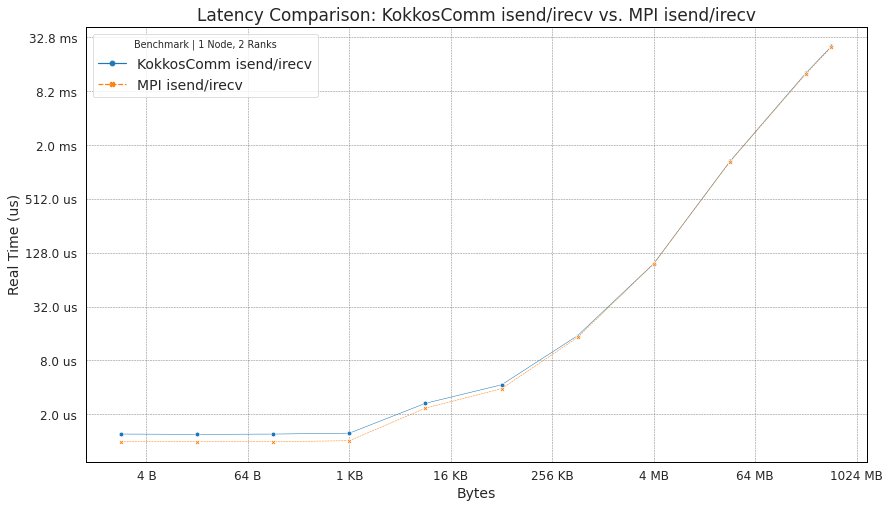

In [7]:
# Plot 2: KokkosComm isend/irecv vs. MPI isend/irecv LOG
plt.figure(figsize=(14, 8))
plt.title('Latency Comparison: KokkosComm isend/irecv vs. MPI isend/irecv', fontsize=fontsize + 4)

sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=.5)

plt.legend(title='Benchmark | 1 Node, 2 Ranks', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=4)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/test_isendirecv_latency.png", dpi=300)
plt.show()

In [8]:
# Open the JSON file for reading
with open('july9onenodeosu.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [9]:
extracted_data = []

# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    
    # Determine the communication type from the name
    if 'KokkosComm' in name:
        comm_type = 'KokkosComm'
    elif 'MPI' in name:
        comm_type = 'MPI'
    else:
        continue  # Skip if neither
        
    # Determine the function type from the name
    if 'sendrecv' in name:
        func_type = 'send/recv'
    elif 'isendirecv' in name:
        func_type = 'isend/irecv'
    else:
        continue  # Skip if neither
        
    # Append the extracted information to the list
    if 'mean' in name:
        extracted_data.append({'comm_type': comm_type, 'func_type': func_type, 'real_time': real_time, 'bytes': bytes})

edf = pd.DataFrame(extracted_data)

# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['comm_type'] + ' ' + edf['func_type']

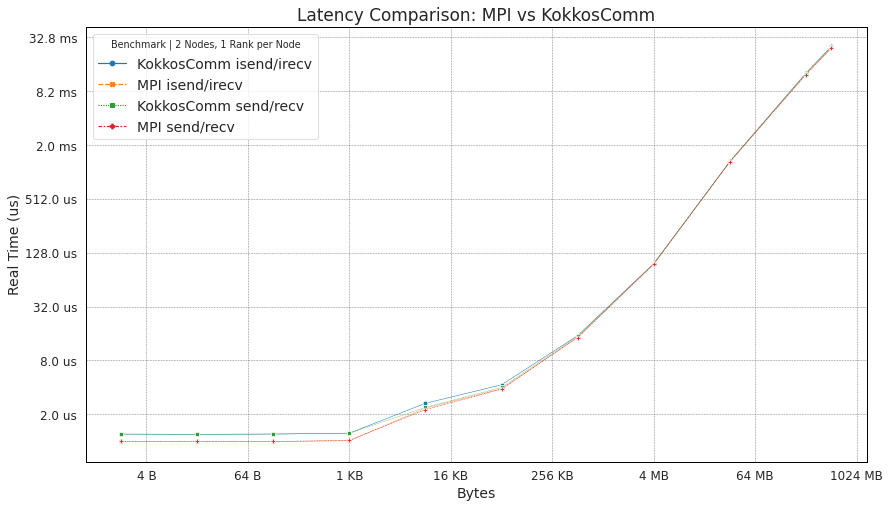

In [10]:
# mpirun -np 2 -npernode 1 --host weaver1,weaver2 ./build/perf_tests/perf_test-main 
# --benchmark_repetitions=5 --benchmark_filter=osu --benchmark_format=json > 
# "output$(date '+%Y%m%d%H%M%S').json"

# Plot 0: Compare All
plt.figure(figsize=(14, 8))
plt.title('Latency Comparison: MPI vs KokkosComm', fontsize=fontsize + 4)

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=.5)

plt.legend(title='Benchmark | 2 Nodes, 1 Rank per Node', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=4)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/osu_latency_all_twonodes.png", dpi=300)
plt.show()

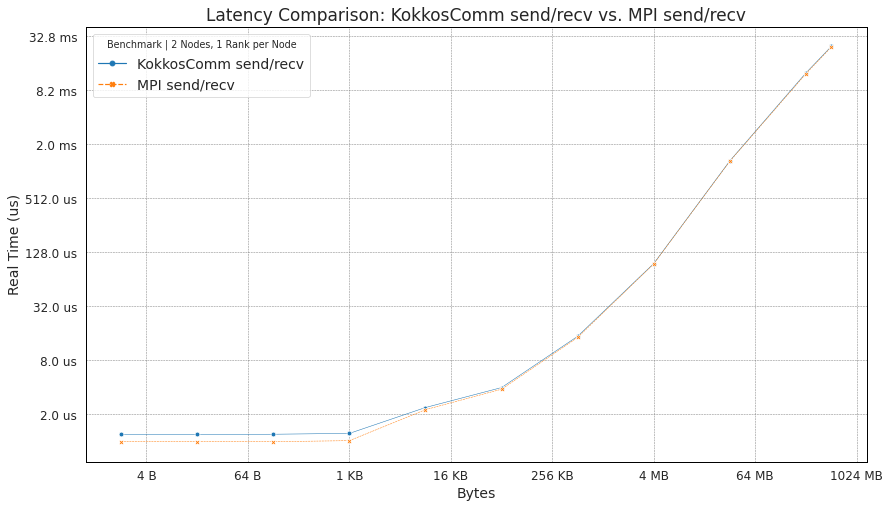

In [11]:
# Plot 1: KokkosComm send/recv vs. MPI send/recv LOG
plt.figure(figsize=(14, 8))
plt.title('Latency Comparison: KokkosComm send/recv vs. MPI send/recv', fontsize=fontsize + 4)
sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=.5)

plt.legend(title='Benchmark | 2 Nodes, 1 Rank per Node', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=4)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/test_sendrecv_latency_twonodes.png", dpi=300)
plt.show()

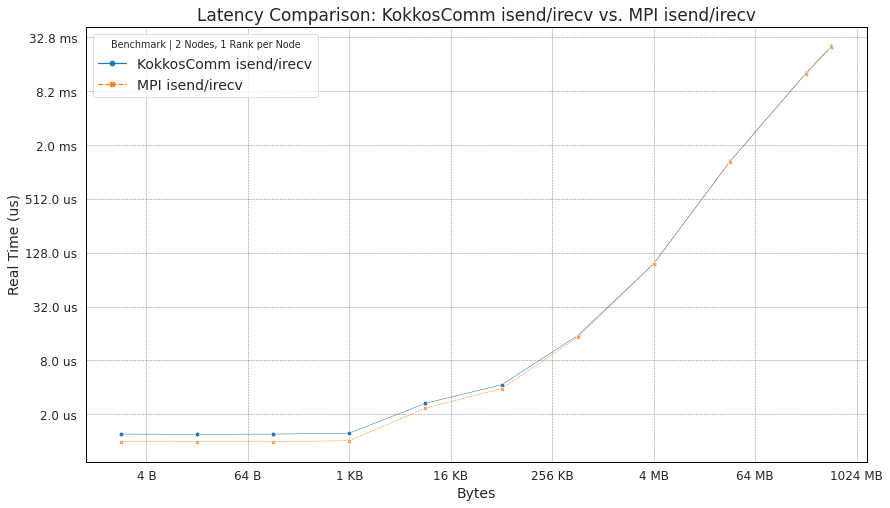

In [12]:
# Plot 2: KokkosComm isend/irecv vs. MPI isend/irecv LOG
plt.figure(figsize=(14, 8))
plt.title('Latency Comparison: KokkosComm isend/irecv vs. MPI isend/irecv', fontsize=fontsize + 4)

sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=.5)

plt.legend(title='Benchmark | 2 Nodes, 1 Rank per Node', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize - 1)
plt.yticks(fontsize=fontsize - 1)

plt.gca().set_xscale("log", base=4)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/test_isendirecv_latency_twonodes.png", dpi=300)
plt.show()